In [37]:
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
import re

In [38]:
df = pd.read_csv("data/bundestag_wp20_speeches_preprocessed.csv")

In [39]:
# Create a dictionary of DataFrames for each party
party_dfs = {party: df[(df["party_clean"] == party) & (df["is_president"] == False)] for party in df["party_clean"].unique()}

# Show available parties
print("Available Parties:", list(party_dfs.keys()))

# Example: Display the first few rows of the SPD party
print(party_dfs["SPD"].head())

Available Parties: ['Die Linke', 'SPD', 'CDU/CSU', 'Bündnis 90/Die Grünen', 'FDP', 'AfD', nan, 'fraktionslos', 'Unknown', 'BSW']
    Unnamed: 0        id               title  \
1        26212  20100100  Gabriele Katzmarek   
8        26219  20100800          Bärbel Bas   
10       26221  20101000        Aydan Özoğuz   
13       26218  20100700  Dr. Rolf Mützenich   
23       26147  20202100      Sabine Dittmar   

                                                 text        date  \
1   \n\nSehr geehrter Herr Alterspräsident! So mus...  2021-10-26   
8   \n\nHerr Alterspräsident, vielen Dank. Ich neh...  2021-10-26   
10  \n\nFrau Präsidentin, ich nehme die Wahl sehr ...  2021-10-26   
13  \n\nSehr geehrter Herr Alterspräsident, die SP...  2021-10-26   
23  \n\nSehr geehrte Frau Präsidentin! Liebe Kolle...  2021-11-11   

    protocol_id protocol_number page_start  page_end topics  ...  \
1          5432            20/1        NaN       NaN    NaN  ...   
8          5432            20/1

In [40]:
print("Available Parties:", list(party_dfs.keys()))

Available Parties: ['Die Linke', 'SPD', 'CDU/CSU', 'Bündnis 90/Die Grünen', 'FDP', 'AfD', nan, 'fraktionslos', 'Unknown', 'BSW']


In [43]:
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
import pickle

def lda_per_party(num_of_topics=10):

     # Create a dictionary and corpus
    party_topics = {}

    # create a dictionary and corpus
    texts = [text.split() for text in df["processed_text"].dropna()]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train LDA model on the whole dataset
    try:
        lda_model = LdaMulticore(corpus, num_topics=num_of_topics, id2word=dictionary, passes=20, random_state=1234)
        # Store the model
        party_topics["All Parties"] = lda_model.print_topics()
    except:
        print("Problem with party: " + str("All Party Model"))
        return

    for party, party_df in party_dfs.items():
        # Tokenize the processed speech texts
        texts = [text.split() for text in party_df["processed_text"].dropna()]

        # Create a dictionary and corpus
        party_corpus = [dictionary.doc2bow(text) for text in texts]
        # Store results
        try:
             # Get topic distribution for this party
            topic_distributions = [lda_model[doc] for doc in party_corpus]

            # Average topic distribution across all speeches
            avg_topic_dist = {f"Topic_{i}": 0 for i in range(num_of_topics)}
            for doc in topic_distributions:
                for topic_id, prob in doc:
                    avg_topic_dist[f"Topic_{topic_id}"] += prob
            avg_topic_dist = {k: v / len(topic_distributions) for k, v in avg_topic_dist.items()} if topic_distributions else avg_topic_dist
            party_topics[party] = avg_topic_dist

            print(avg_topic_dist)

        except:
            print("Problem with party: " + str(party))

    df_reduced = df[["processed_text", "party_clean"]]

    results = [party_topics, lda_model, dictionary, df_reduced]

    filename = "results/lda_per_party_results_" + str(num_of_topics)

    with open(filename, "wb") as fp:
        pickle.dump(results, fp)

    return party_topics

In [44]:
# what do i want to save:
#  global model, global topics
#  avg distribution per party

In [45]:
topics_5 = lda_per_party(5)


{'Topic_0': 0.3092217393371546, 'Topic_1': 0.24462183874982696, 'Topic_2': 0.20465395769204667, 'Topic_3': 0.061100304019963664, 'Topic_4': 0.17536974925176818}
{'Topic_0': 0.3008391721250983, 'Topic_1': 0.31302836271327505, 'Topic_2': 0.23282542029511968, 'Topic_3': 0.0781522939374938, 'Topic_4': 0.07138124189858887}
{'Topic_0': 0.3559795689288969, 'Topic_1': 0.28289725253027354, 'Topic_2': 0.2288147369276212, 'Topic_3': 0.04476396187910594, 'Topic_4': 0.08280788121052629}
{'Topic_0': 0.2891391291718104, 'Topic_1': 0.31564462204700866, 'Topic_2': 0.24278159089949114, 'Topic_3': 0.07245810515327826, 'Topic_4': 0.07531940656000619}
{'Topic_0': 0.30757401320753236, 'Topic_1': 0.33018598256478227, 'Topic_2': 0.2395828660656527, 'Topic_3': 0.05851561822270814, 'Topic_4': 0.05984057600700587}
{'Topic_0': 0.2524509172737127, 'Topic_1': 0.17336488294511626, 'Topic_2': 0.2098470226611261, 'Topic_3': 0.04736399123258454, 'Topic_4': 0.31184168251760397}
{'Topic_0': 0, 'Topic_1': 0, 'Topic_2': 0,

In [46]:
topics_5

{'All Parties': [(0,
   '0.008*"Mensch" + 0.007*"Jahr" + 0.007*"gut" + 0.006*"mehr" + 0.006*"Euro" + 0.006*"Land" + 0.006*"Kollege" + 0.006*"ja" + 0.005*"werden" + 0.004*"Fraktion"'),
  (1,
   '0.007*"gut" + 0.006*"mehr" + 0.006*"ja" + 0.006*"Jahr" + 0.006*"Deutschland" + 0.005*"Kollege" + 0.005*"Land" + 0.004*"wichtig" + 0.004*"groß" + 0.004*"dafür"'),
  (2,
   '0.007*"Deutschland" + 0.007*"Land" + 0.006*"Jahr" + 0.005*"werden" + 0.005*"Mensch" + 0.005*"deutsch" + 0.004*"Kollege" + 0.004*"mehr" + 0.004*"gut" + 0.004*"heute"'),
  (3,
   '0.007*"Mensch" + 0.006*"gut" + 0.006*"Antrag" + 0.006*"drucksach" + 0.006*"Gesetz" + 0.005*"mehr" + 0.005*"Land" + 0.005*"Fraktion" + 0.004*"gemäß" + 0.004*"wichtig"'),
  (4,
   '0.007*"mehr" + 0.007*"Jahr" + 0.006*"Deutschland" + 0.005*"ja" + 0.005*"gut" + 0.005*"Frau" + 0.005*"Euro" + 0.004*"Prozent" + 0.004*"deutsch" + 0.004*"Land"')],
 'Die Linke': {'Topic_0': 0.3092217393371546,
  'Topic_1': 0.24462183874982696,
  'Topic_2': 0.20465395769204667,
 

In [4]:
#Loading of the results:
import pickle

with open("results/lda_per_party", "rb") as fp:
    party_topics_Test = pickle.load(fp)

In [5]:
party_topics_Test


{'Die Linke': [(0,
   '0.010*"sagen" + 0.007*"Jahr" + 0.007*"werden" + 0.007*"ja" + 0.007*"geben" + 0.006*"mal" + 0.005*"Krieg" + 0.005*"Land" + 0.005*"Kollege" + 0.005*"gehen"'),
  (1,
   '0.011*"Mensch" + 0.007*"mehr" + 0.006*"Jahr" + 0.006*"vieler" + 0.006*"müssen" + 0.005*"geben" + 0.005*"werden" + 0.005*"sagen" + 0.005*"gut" + 0.005*"afd"'),
  (2,
   '0.007*"sagen" + 0.006*"geben" + 0.005*"mehr" + 0.004*"ja" + 0.004*"gut" + 0.004*"müssen" + 0.004*"Herr" + 0.004*"brauchen" + 0.004*"gehen" + 0.003*"vieler"'),
  (3,
   '0.007*"Antrag" + 0.004*"Union" + 0.003*"dank" + 0.003*"werden" + 0.003*"geben" + 0.003*"Fraktion" + 0.003*"mehr" + 0.003*"vieler" + 0.003*"fordern" + 0.002*"müssen"'),
  (4,
   '0.004*"sein" + 0.003*"afd" + 0.003*"Wissenschaft" + 0.002*"deutsch" + 0.002*"gehen" + 0.002*"ja" + 0.002*"Thema" + 0.002*"gut" + 0.002*"werden" + 0.002*"geben"'),
  (5,
   '0.007*"mehr" + 0.006*"gut" + 0.006*"sagen" + 0.005*"müssen" + 0.005*"Jahr" + 0.005*"brauchen" + 0.005*"Deutschland" + 0.0

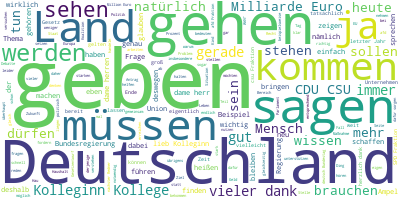

In [20]:
#WORDCLOUD AS EXTRAPOLARYY DATA ANALYSIS
from wordcloud import WordCloud

long_string = ','.join(list(df['processed_text'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()